# Normalization

Normalization is a fundamental principle in relational database design that ensures data integrity, eliminates redundancy, and creates maintainable schemas. Understanding normalization helps you design databases that are robust, efficient, and accurately represent your domain.


## Why Normalization Matters

Poor database design leads to serious problems:

1. **Update Anomalies**: When the same data is stored in multiple places, updates must be made in all locations or inconsistencies arise
2. **Insertion Anomalies**: Cannot add certain data without having other, unrelated data present
3. **Deletion Anomalies**: Deleting one piece of information inadvertently removes other important data
4. **Data Redundancy**: Unnecessary duplication wastes storage and creates maintenance overhead

**Example of unnormalized data:**

```
Employee Project Table (BAD DESIGN)
┌─────────────┬──────────┬────────────┬─────────────┬──────────────┐
│ project_id* │ emp_name │ dept_name  │ dept_phone  │ project_name │
├─────────────┼──────────┼────────────┼─────────────┼──────────────┤
│ P1          │ Alice    │ Engineering│ 555-0100    │ Database     │
│ P2          │ Alice    │ Engineering│ 555-0100    │ API          │
│ P3          │ Bob      │ Sales      │ 555-0200    │ Marketing    │
└─────────────┴──────────┴────────────┴─────────────┴──────────────┘

Problems:
- Alice's department info is duplicated (redundancy)
- If department phone changes, must update multiple rows (update anomaly)
- Cannot add a department without a project (insertion anomaly)
- Deleting last project removes department info (deletion anomaly)
```

Normalization solves these problems by organizing data into well-structured tables.


## Classical Normalization Theory

Edgar F. Codd developed formal normalization theory in the early 1970s, **before** the Entity-Relationship model existed. His approach is based on **functional dependencies** between attributes and provides mathematical rigor for database design.

The classical normal forms form a progression, each building on the previous one and addressing specific types of problems [@10.1145/358024.358054]. Let's examine each with examples.


### First Normal Form (1NF)

**Definition**: All attributes must contain **atomic (indivisible) values**. No repeating groups or arrays.

**Problem**: Non-atomic values make it difficult to query specific items and violate the relational model's requirement that each cell contains a single value.

**Example - Violation of 1NF:**

```
Student Course Registration (VIOLATES 1NF)
┌─────────────┬──────────┬─────────────────────────┐
│ student_id* │ name     │ courses                 │
├─────────────┼──────────┼─────────────────────────┤
│ 1           │ Alice    │ Math, Physics, Chemistry│  ← Non-atomic!
│ 2           │ Bob      │ Physics, Biology        │  ← Non-atomic!
└─────────────┴──────────┴─────────────────────────┘

Student Course Registration (VIOLATES 1NF)
┌─────────────┬──────────┬──────────┬─────────┬──────────┐
│ student_id* │ name     │ course1  | course2 | course3  │
├─────────────┼──────────┼──────────┼─────────┼──────────┤
│ 1           │ Alice    │ Math     | Physics | Chemistry│  ← Repeated groups
│ 2           │ Bob      │ Physics  | Biology │ NULL     │
└─────────────┴──────────┴──────────┴─────────┴──────────┘


Problem: Cannot easily query "who is taking Physics?"
```

**Normalized to 1NF:**

```
Student table:               Enrollment table:
┌─────────────┬──────────┐   ┌─────────────┬───────────┐
│ student_id* │ name     │   │ student_id* │ course*   │
├─────────────┼──────────┤   ├─────────────┼───────────┤
│ 1           │ Alice    │   │ 1           │ Math      │
│ 2           │ Bob      │   │ 1           │ Physics   │
└─────────────┴──────────┘   │ 1           │ Chemistry │
                             │ 2           │ Physics   │
                             │ 2           │ Biology   │
                             └─────────────┴───────────┘
```

Now each cell contains a single atomic value, and queries are straightforward.


### Second Normal Form (2NF)

**Definition**: Must be in 1NF, and all non-key attributes must depend on the **entire primary key**, not just part of it.

This only applies to tables with **composite primary keys** (multiple columns). It addresses **partial dependencies**.

**Problem**: When non-key attributes depend on only part of the composite key, you get redundancy and update anomalies.

**Example - Violation of 2NF:**

```
Enrollment table with composite key (student_id, course_id)
┌────────────┬───────────┬──────────────┬──────────────┬───────────────┐
│*student_id │*course_id │ student_name │ student_email│ course_title  │
├────────────┼───────────┼──────────────┼──────────────┼───────────────┤
│ 1          │ CS101     │ Alice        │ a@edu.com    │ Databases     │
│ 1          │ CS102     │ Alice        │ a@edu.com    │ Algorithms    │ ← Redundant!
│ 2          │ CS101     │ Bob          │ b@edu.com    │ Databases     │ ← Redundant!
└────────────┴───────────┴──────────────┴──────────────┴───────────────┘

Problems:
- student_name depends only on student_id (partial dependency)
- student_email depends only on student_id (partial dependency)
- course_title depends only on course_id (partial dependency)
- Redundancy: Alice's info repeated, "Databases" title repeated
- Update anomaly: Changing Alice's email requires multiple updates
```

**Normalized to 2NF:**

```
Student table:                Course table:              Enrollment table:
┌────────────┬──────┬───────┐ ┌───────────┬──────────┐ ┌────────────┬───────────┐
│*student_id │ name │ email │ │*course_id │ title    │ │*student_id │*course_id │
├────────────┼──────┼───────┤ ├───────────┼──────────┤ ├────────────┼───────────┤
│ 1          │ Alice│ a@edu │ │ CS101     │ Databases│ │ 1          │ CS101     │
│ 2          │ Bob  │ b@edu │ │ CS102     │ Algos    │ │ 1          │ CS102     │
└────────────┴──────┴───────┘ └───────────┴──────────┘ │ 2          │ CS101     │
                                                       └────────────┴───────────┘
```

Now each attribute depends on the entire primary key of its table. No redundancy, no partial dependencies.


### Third Normal Form (3NF)

**Definition**: Must be in 2NF, and no non-key attribute can depend on another non-key attribute. Eliminates **transitive dependencies**.

**Problem**: When attribute A depends on the primary key, and attribute B depends on A (not directly on the key), you have a transitive dependency: `PK → A → B`.

**Example - Violation of 3NF:**

```
Student table
┌────────────┬──────────┬─────────────┬────────────┬──────────────┐
│*student_id │ name     │ department  │ dept_name  │ dept_building│
├────────────┼──────────┼─────────────┼────────────┼──────────────┤
│ 1          │ Alice    │ CS          │ Comp Sci   │ Building A   │
│ 2          │ Bob      │ CS          │ Comp Sci   │ Building A   │ ← Redundant!
│ 3          │ Carol    │ MATH        │ Mathematics│ Building B   │
│ 4          │ Dave     │ CS          │ Comp Sci   │ Building A   │ ← Redundant!
└────────────┴──────────┴─────────────┴────────────┴──────────────┘

Problems:
- dept_name depends on department, not directly on student_id
- dept_building depends on department, not directly on student_id
- Transitive dependency: student_id → department → dept_name
- Redundancy: CS department info repeated three times
- Update anomaly: If CS department moves buildings, must update multiple rows
- Deletion anomaly: If all CS students leave, we lose CS department info
```

**Normalized to 3NF:**

```
Student table:                    Department table:
┌────────────┬──────┬────────┐   ┌─────────────┬─────────┬──────────┐
│*student_id │ name │ dept   │   │*dept_code   │ name    │ building │
├────────────┼──────┼────────┤   ├─────────────┼─────────┼──────────┤
│ 1          │ Alice│ CS     │   │ CS          │ Comp Sci│ Bldg A   │
│ 2          │ Bob  │ CS     │   │ MATH        │ Math    │ Bldg B   │
│ 3          │ Carol│ MATH   │   └─────────────┴─────────┴──────────┘
│ 4          │ Dave │ CS     │
└────────────┴──────┴────────┘
```

Now department information is stored once, and there are no transitive dependencies. Each attribute directly depends on its table's primary key.


### The Classical Approach: Strengths and Limitations

**The famous mnemonic**: "Every non-key attribute must depend on the key, the whole key, and nothing but the key ... and so help me Codd."

**Strengths:**
- Mathematically rigorous and well-defined
- Addresses specific, identifiable problems
- Forms the theoretical foundation of database design

**Limitations:**
- Requires identifying all functional dependencies (can be complex)
- Focuses on attribute-level dependencies rather than entities
- Can be difficult to apply intuitively in practice
- Developed before entity-relationship thinking became standard

**Key insight**: The classical approach achieves correct results but requires abstract reasoning about functional dependencies. 

DataJoint takes a different approach: rather than analyzing attribute dependencies, it emphasizes **entities and their properties**—a more intuitive framework that maps naturally to how we conceptualize real-world domains.


## DataJoint's Normalization Principles

DataJoint emphasizes **entities and their intrinsic properties** rather than functional dependencies between attributes. This entity-centric approach emerged after the development of the Entity-Relationship model and maps naturally to how we think about real-world domains.

### The Core Principle

> **Every table must represent a well-defined entity type, and all attributes in that table must describe that entity type directly and only that entity type.**

Or more memorably:

> **"Each table contains attributes about the entity, the whole entity, and nothing but the entity."**

This principle leads to three practical rules:


### Rule 1: One Entity Type Per Table

Each table represents exactly one class of entity. Don't mix different entity types in the same table.

**Questions to ask:**
- What entity type does this table represent?
- Are all rows instances of the same kind of thing?

### Rule 2: Attributes Describe Only That Entity

Every attribute must be an intrinsic property of the entity, not of some related entity.

**Questions to ask:**
- Does this attribute describe the entity identified by the primary key?
- Would this attribute still apply if the entity's relationships changed?
- Is this a property of THIS entity or of a different entity?

### Rule 3: Separate Changeable Attributes

Include only **permanent, intrinsic attributes** with each entity. Attributes that change over time should be modeled as separate entities (typically association entities or extensions of the main entity).

**Questions to ask:**
- Is this attribute permanent for the entity's lifetime?
- If it changes, does the entity become "a different entity" or just "the same entity with updated info"?
- Do I need to preserve history of changes?

**Decision rule:**
- **Permanent** → Include in entity table (e.g., `Mouse.date_of_birth`, `Mouse.sex`)
- **Changeable** → Create separate table (e.g., `CageAssignment`, `WeightMeasurement`)


## Practical Example: Animal Research Lab

Let's apply these principles to design a schema for tracking mice in a research lab.


### ❌ Poor Design (Violates Normalization)


```python
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int
    ---
    date_of_birth : date          # ✓ Permanent property of mouse
    sex : enum('M', 'F')          # ✓ Permanent property of mouse
    cage_id : int                 # ✗ CHANGEABLE - violates Rule 3
    current_weight : decimal(5,2) # ✗ CHANGEABLE - violates Rule 3
    cage_location : varchar(50)   # ✗ Property of CAGE, not mouse - violates Rule 2
    cage_capacity : int           # ✗ Property of CAGE, not mouse - violates Rule 2
    """
```

## DataJoint's Workflow Perspective

A fundamental insight underlying DataJoint's normalization approach: **databases are workflows where downstream data depends on the integrity of upstream data**.

This workflow-centric view fundamentally shapes normalization principles and explains why DataJoint emphasizes immutability and avoidance of updates.


### Databases as Data Dependency Graphs

**Traditional database thinking** emphasizes:
- Transactions (e.g., moving money between accounts)
- Current state (e.g., what is the balance now?)
- Updates to reflect real-world changes

**DataJoint's workflow thinking** emphasizes:
- Data pipelines (derive results from source data through computational steps)
- Data provenance (what upstream data produced these results?)
- Immutable facts (each record represents a fact at a specific point in time)

In DataJoint, tables form a **directed acyclic graph (DAG)** of dependencies, much like a computational workflow.


### Example: Neuroscience Pipeline

Consider a typical neuroscience workflow:

```
Session                    ← Manual: Experimenter enters session info
    ↓ (foreign key)
Recording                  ← Imported: Data acquisition writes raw signals
    ↓ (foreign key)
FilteredRecording         ← Computed: applies filters to Recording
    ↓ (foreign key)
SpikeSorting              ← Computed: detects spikes in FilteredRecording
    ↓ (foreign key)
NeuronStatistics          ← Computed: analyzes SpikeSorting results
```

**Each downstream table depends on upstream data:**
- `FilteredRecording` is computed FROM `Recording` data
- `SpikeSorting` is computed FROM `FilteredRecording` data
- `NeuronStatistics` is computed FROM `SpikeSorting` data

**Critical implication**: If upstream data changes, all downstream results become invalid.


### Why Updates Break Workflows

In a workflow/pipeline view, **updates to upstream data silently invalidate downstream results**:

**Scenario**: You discover the sampling rate in `Recording` for `{'session': 42}` was recorded incorrectly.

**If you UPDATE:**
```python
# Fix the sampling rate
Recording.update1({'session': 42, 'sampling_rate': 30000})  # Was 20000, should be 30000

# But now:
# - FilteredRecording(42) was computed using sampling_rate=20000
# - SpikeSorting(42) was computed from FilteredRecording with wrong rate
# - NeuronStatistics(42) was computed from SpikeSorting with wrong rate
#
# All downstream results are INVALID, but the database doesn't know!
# No error, no warning, no indication of the problem.
# The data looks fine but the science is wrong.
```

**If you use DELETE (forced by immutability):**
```python
# Try to fix by deleting and reinserting
(Recording & {'session': 42}).delete()
# Propagates the delete for session=42 to all downstream tables that depend on it:
# - FilteredRecording
# - SpikeSorting
# - NeuronStatistics

# Reinsert with correct data
Recording.insert1({'session': 42, 'sampling_rate': 30000, ...})

# Recompute entire pipeline
FilteredRecording.populate({'session': 42})
SpikeSorting.populate({'session': 42})
NeuronStatistics.populate({'session': 42})

# Now ALL results are consistent and scientifically valid
```

The dependency chain is **explicit** and **enforced**.


### How Workflow Thinking Leads to Normalization Principles

The workflow perspective directly motivates DataJoint's normalization principles:

**1. Immutability (INSERT/DELETE, not UPDATE)**
- **Why**: Updates hide broken dependencies in the workflow
- **Workflow view**: Upstream data is "input" to downstream computations—changing input invalidates output
- **Solution**: DELETE forces explicit handling of all dependent data

**2. Separate Changeable Attributes (Rule 3)**  
- **Why**: Time-varying properties represent different states in the workflow
- **Workflow view**: Each state is a distinct input that produces distinct outputs
- **Solution**: Model states as separate records (INSERTs), not updates to existing records

**3. Entities with Only Intrinsic Properties (Rules 1 & 2)**
- **Why**: Properties of different entities are at different nodes in the dependency graph
- **Workflow view**: Each entity type represents a distinct stage or data type in the pipeline
- **Solution**: Separate entity types into separate tables to make dependencies explicit

### The Key Insight

> **In workflow-centric databases, referential integrity isn't just about preventing orphaned records—it's about ensuring computational validity.**

Foreign keys don't just link data; they represent **data provenance**:
- "This result was computed FROM this input"
- "This analysis is BASED ON this measurement"  
- "This conclusion DEPENDS ON this observation"

When you UPDATE input data but leave outputs unchanged, you break the provenance chain. The outputs claim to be based on inputs that no longer exist (in their original form).

**DataJoint's normalization principles ensure that data dependencies remain explicit and enforceable, making workflows scientifically reproducible and computationally sound.**


**Problems with this design:**

1. **Mixes entity types**: Contains both mouse properties AND cage properties
2. **Requires updates**: When a mouse moves cages or gains weight, we must UPDATE the row
3. **Redundant data**: If multiple mice share a cage, cage location and capacity are duplicated
4. **Loses history**: When a mouse moves or weight changes, old values are lost


### Why DataJoint Relies on INSERT and DELETE

DataJoint provides the `update1()` method to update secondary attributes in an existing row, but it is intended for **surgical correction of data anomalies**—fixing errors that should not have occurred—not for regular data manipulation.

#### UPDATE is Available But Not for Regular Operations

The philosophy: if you find yourself using UPDATE frequently in normal workflows, it indicates a schema design  that does not match the operations of your enterprise.

**When UPDATE is appropriate:**
- ✅ Correcting data entry errors (e.g., mouse sex was recorded incorrectly) -- but only if it is known that none of the downstream data depends on the attribute that is being updated.

In all other cases, it is more appropriate to delete the old record and to re-populate the downstream data from the primary data.

#### Reason 1: Well-Normalized Schemas Don't Need Regular Updates

In a properly normalized schema:
- **Permanent attributes** never change (they're intrinsic to the entity)
- **Time-varying attributes** are in separate tables with date/time in the primary key
- "Changing" means adding new records (INSERT) or removing invalid ones (DELETE)

**Example: Mouse Weight Over Time**


```python
# ❌ Bad: Requires UPDATE for normal operations
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int
    ---
    current_weight : decimal(5,2)  # Must UPDATE every time weight changes!
    """

# Mouse weighs 25g today
Mouse.insert1({'mouse_id': 1, 'current_weight': 25.0})
# A week later, weighs 27g - requires UPDATE
Mouse.update1({'mouse_id': 1, 'current_weight': 27.0})  # Loses history!
```

```python
# ✅ Good: Uses INSERT for normal operations
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int
    ---
    sex : enum('M', 'F')           # Permanent—never changes
    date_of_birth : date           # Permanent—never changes
    """

@schema
class WeightMeasurement(dj.Manual):
    definition = """
    -> Mouse
    measurement_date : date        # Part of primary key to preserve history
    ---
    weight : decimal(5,2)
    """

# Mouse weighs 25g today
WeightMeasurement.insert1(
    {'mouse_id': 1, 'measurement_date': '2024-01-01', 'weight': 25.0})
# A week later, weighs 27g - just INSERT
WeightMeasurement.insert1(
    {'mouse_id': 1, 'measurement_date': '2024-01-08', 'weight': 27.0})
# History preserved! Can see weight trajectory
```

#### Reason 2: Foreign Keys Reference Complete Tuples

Foreign keys establish relationships between **entire tuples**, not just ID columns:

```python
-> Mouse  # References the complete tuple: (mouse_id, sex, date_of_birth)
```

When you UPDATE an attribute in the parent tuple, you logically create a "different" tuple:
- The foreign key constraint is still technically satisfied (the ID matches)
- But the semantic relationship is broken (child references old values, parent has new values)
- This violates referential integrity at the logical level

**Example:**


```python
# Mouse table
Mouse.insert1({'mouse_id': 1, 'sex': 'M', 'date_of_birth': '2024-01-01'})

# Experiment references this specific mouse
Experiment.insert1({'experiment_id': 100, 'mouse_id': 1, 'date': '2024-06-01'})
# Semantically: "Experiment 100 was performed on the male mouse born 2024-01-01"

# Later, realize sex was recorded wrong - UPDATE
Mouse.update1({'mouse_id': 1, 'sex': 'F'})
# Now Experiment 100 references a different logical entity!
# It claims to be on "male mouse born 2024-01-01" but that tuple no longer exists
# The relationship is semantically broken, even though FK constraint is satisfied

# DELETE makes this explicit:
(Mouse & {'mouse_id': 1}).delete()  # ERROR: Experiment references this mouse!
# Forces you to delete and repopulate the dependent data
```

#### Reason 3: Updates Bypass Data Dependency Checks

In computational workflows, downstream data is derived from upstream data. UPDATE creates silent inconsistencies; DELETE makes dependencies explicit.

**Example: Image Processing Pipeline**


```python

# Pipeline: RawImage → PreprocessedImage → SegmentedCells → CellActivity

# Original data and processing
RawImage.insert1({'image_id': 42, 'brightness': 1.0, 'contrast': 1.0})
PreprocessedImage.populate()  # Derives from RawImage(42) with brightness=1.0
SegmentedCells.populate()     # Derives from PreprocessedImage(42)
CellActivity.populate()       # Derives from SegmentedCells(42)

# Discover image brightness was wrong - need to fix

# ❌ Using UPDATE - silent inconsistency:
RawImage.update1({'image_id': 42, 'brightness': 1.5})
# No error! But...
# - PreprocessedImage was computed with brightness=1.0
# - SegmentedCells was computed from OLD preprocessed image
# - CellActivity was computed from OLD segmentation
# All downstream results are now invalid but database doesn't know!

# ✅ Using DELETE - explicit dependency handling:
(RawImage & {'image_id': 42}).delete()
# This delete will cascade to the dependent tables for image_id=42, 
# in reverse order of dependency:
# CellActivity 
# SegmentedCells
# PreprocessedImage
# RawImage

# Now reinsert and recompute entire pipeline
RawImage.insert1({'image_id': 42, 'brightness': 1.5, 'contrast': 1.0})
PreprocessedImage.populate()  # Recomputes with correct brightness
SegmentedCells.populate()     # Recomputes from new preprocessed image
CellActivity.populate()       # Recomputes from new segmentation
# All results are now consistent!
```

### The Philosophy: Updates as a Design Smell

**Key insight**: In a well-designed DataJoint schema, regular operations flow naturally through INSERT and DELETE alone. If you need UPDATE as part of normal workflows, it's a signal that:

1. **Changeable attributes weren't separated** → Violates Rule 3
2. **Entities are poorly defined** → Violates Rules 1 & 2  
3. **Time-varying data isn't properly modeled** → Missing time-series tables

**The test**: Can your normal data operations be expressed purely as INSERT and DELETE?
- ✅ **Yes** → Schema is well-normalized and immutability-ready
- ❌ **No** → Schema needs redesign

**UPDATE exists** for the rare cases when data corruption or entry errors must be corrected surgically. It's a maintenance tool, not an operational tool.


### ✅ Good Design (Properly Normalized)


[2025-10-09 18:54:44,328][INFO]: DataJoint 0.14.6 connected to dev@db:3306


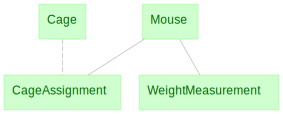

In [1]:
import datajoint as dj
schema = dj.Schema('mouse_cage')

# Entity 1: Mouse - contains ONLY permanent mouse properties
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int
    ---
    date_of_birth : date          # ✓ Permanent property of mouse
    sex : enum('M', 'F')          # ✓ Permanent property of mouse
    """

# Entity 2: Cage - contains ONLY cage properties
@schema
class Cage(dj.Manual):
    definition = """
    cage_id : int
    ---
    location : varchar(50)        # ✓ Property of cage
    capacity : int                # ✓ Property of cage
    """

# Entity 3: CageAssignment - represents the relationship (changeable over time)
@schema
class CageAssignment(dj.Manual):
    definition = """
    -> Mouse
    assignment_date : date        # Part of primary key - tracks assignment history
    ---
    -> Cage
    """

# Entity 4: WeightMeasurement - time-series of measurements
@schema
class WeightMeasurement(dj.Manual):
    definition = """
    -> Mouse
    measurement_date : date        # Part of primary key - tracks measurement history
    ---
    weight : decimal(5,2)         # ✓ Weight at this specific date
    """

dj.Diagram(schema)


**Why this is better:**

1. **✅ Rule 1 (One entity per table)**: Four distinct entity types, each in its own table
2. **✅ Rule 2 (Attributes describe only that entity)**: Mouse table has only mouse properties; Cage table has only cage properties
3. **✅ Rule 3 (Separate changeable attributes)**: Cage assignments and weights are in separate tables
4. **No updates needed**: Moving a mouse means DELETE old assignment + INSERT new assignment
5. **No redundancy**: Cage properties stored once, referenced by assignments
6. **History preserved**: Can track all past cage assignments and weight measurements
7. **Immutable entities**: Mouse and Cage entities never change once created


## The Immutability Principle

A key insight in DataJoint's normalization philosophy: **well-normalized schemas naturally support immutable entities**.

### Entities as Immutable Tuples

**Concept**: Each row (tuple) represents an immutable entity. Once created, entities are not modified—only created or destroyed.

**Operations:**
- ✅ **INSERT**: Create new entities
- ✅ **DELETE**: Remove entities
- ❌ **UPDATE**: Avoided by design

### Why Immutability Matters

1. **Foreign keys reference complete tuples**: When a table references another via foreign key, it references the entire entity, not just individual attributes. Updates can break these relationships in subtle ways.

2. **Workflows and data dependencies**: In computational pipelines, downstream data is derived from upstream data. Updating upstream data invalidates downstream results, but foreign key constraints won't detect this. Deletion forces you to explicitly address dependencies.

3. **History and audit trails**: Immutable records naturally preserve history. Changes are represented as new records, not modifications to existing ones.

4. **Parallel processing**: Immutable data can be safely read by multiple processes without locks.


### Example: Data Pipeline and Immutability

Consider an image processing pipeline:

```
RawImage → PreprocessedImage → SegmentedCells → CellActivity
```

**If you UPDATE `RawImage` parameters:**
- ✗ All downstream data (`PreprocessedImage`, `SegmentedCells`, `CellActivity`) becomes invalid
- ✗ No error is raised—the inconsistency is silent
- ✗ Results are now based on mismatched inputs

**If you DELETE and re-INSERT `RawImage`:**
- ✓ Foreign key constraint prevents deletion while downstream data exists
- ✓ Forces you to delete the entire downstream pipeline first
- ✓ Then recompute everything with correct parameters
- ✓ Data dependencies are explicit and enforced

This is why normalization naturally leads to immutability: properly normalized schemas make data dependencies explicit through foreign keys, and immutability ensures those dependencies remain valid.


## Additional Example: E-commerce System

Another domain to illustrate the principles:


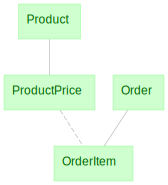

In [5]:
schema = dj.Schema('ecommerce')

# Permanent product properties
@schema
class Product(dj.Manual):
    definition = """
    product_id : int
    ---
    name : varchar(100)           # ✓ Permanent
    description : varchar(500)    # ✓ Permanent
    manufacturer : varchar(100)   # ✓ Permanent
    # NOT current_price - prices change!
    """

# Changeable pricing - separate entity
@schema
class ProductPrice(dj.Manual):
    definition = """
    -> Product
    effective_date : date         # When this price became effective
    ---
    price : decimal(10,2)
    """

@schema
class Order(dj.Manual):
    definition = """
    order_id : int
    """

# Customer orders reference the product, not a specific price
@schema
class OrderItem(dj.Manual):
    definition = """
    -> Order
    item_number : int
    ---
    -> ProductPrice               # Which price was in effect
    quantity : int
    """

dj.Diagram(schema)

**Key insight**: Price is a time-varying property, so it becomes its own entity rather than an attribute of Product. Order items reference both the specific product price and, transitively, the product itself, preserving historical accuracy.


## Classical vs. DataJoint Normalization

Both approaches achieve the same goal—well-structured, anomaly-free databases—but through different reasoning:

| Aspect | Classical (Codd) | DataJoint |
|--------|------------------|-----------|
| **Foundation** | Functional dependencies between attributes | Entities and their intrinsic properties |
| **Question** | "What attributes determine what other attributes?" | "What entity types exist and what are their properties?" |
| **Method** | Identify dependencies, decompose to eliminate violations | Design tables representing coherent entity types |
| **Era** | Pre-Entity-Relationship model (1970s) | Post-ER model (leverages intuitive entity thinking) |
| **Complexity** | Requires formal analysis of dependencies | Natural mapping to domain understanding |
| **Result** | Same normalized structure | Same normalized structure |

**The key difference**: DataJoint's entity-centric approach is easier to understand and apply because it maps directly to how we conceptualize domains—as collections of entities with properties—rather than as abstract attribute dependencies.


## Summary: DataJoint Normalization Principles

### The Core Principle

> **Every table must represent a well-defined entity type, and all attributes must describe that entity type directly and only that entity type.**

### Three Practical Rules

1. **One Entity Type Per Table**
   - Each table represents exactly one class of entity
   - Don't mix different entity types

2. **Attributes Describe Only That Entity**
   - Every attribute is an intrinsic property of the entity
   - Not properties of related entities (use foreign keys for relationships)

3. **Separate Changeable Attributes**
   - Include only permanent attributes with each entity
   - Model time-varying properties as separate tables

### The Immutability Principle

- Entities are **immutable**: use INSERT and DELETE, not UPDATE
- Foreign keys reference complete tuples, not just IDs
- Ensures data pipeline consistency and dependency tracking
- Naturally preserves history and audit trails

### Design Questions to Ask

For each table:
1. What entity type does this represent?
2. Are all attributes intrinsic properties of that entity?
3. Are all attributes permanent for the entity's lifetime?

If the answer to any question is "no," the table needs restructuring.


### Benefits of Proper Normalization

When these principles are followed:

- ✅ **Data Integrity**: Each fact stored in exactly one place
- ✅ **No Anomalies**: Update, insertion, and deletion anomalies eliminated
- ✅ **Consistency**: Changes propagate correctly through foreign key relationships
- ✅ **Maintainability**: Changes are localized to specific tables
- ✅ **Clear Structure**: Schema reflects domain entities intuitively
- ✅ **Immutability**: Entities remain stable; changes are tracked explicitly
- ✅ **History Preservation**: Time-varying data naturally preserved in separate tables
- ✅ **Pipeline Integrity**: Data dependencies are explicit and enforced

### Practical Application

When designing or reviewing a schema:

1. **Identify entity types** in your domain
2. **For each entity**, determine its permanent, intrinsic properties
3. **Separate entities** into distinct tables
4. **Model relationships** with foreign keys and association entities
5. **Extract time-varying properties** into separate entities
6. **Verify** each table passes the three-question test

This entity-centric approach achieves the same rigor as classical normalization but is much more intuitive and practical, especially for complex scientific and computational workflows.
